In [2]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import umap
import sys
import os
import glob
# from ukbb_cardiac.data.biobank_utils import *
import dateutil.parser
import zipfile
import shutil
import warnings
%matplotlib inline

In [5]:
import sys
import os
import glob
import pandas as pd
# from ukbb_cardiac.data.biobank_utils import *
import dateutil.parser
import zipfile
import shutil
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

# read paths of dicom files (zip only)

file_list = pd.read_csv("../dicom_list_baseline.txt",header=None)
file_list['id'] = [file.split("/")[-1].split("_")[0] for file in file_list[0]]


file_list_0 = file_list[0].tolist()
# Remove CINE
file_list_0 = [item for item in file_list_0 if 'CINE' not in item]

file_list_zip = [file.split("/")[-1].split("_")[0] for file in file_list_0]
file_list_zip_unique = list(sorted((set(file_list_zip))))


cnt_check = pd.DataFrame(file_list_zip, columns = ['id'])
# cnt_check['id2'] = cnt_check['id']
# cnt_check['cnt'] = cnt_check.groupby(by = ['id2']).count()
cnt_check_group = pd.DataFrame(cnt_check.value_counts(), columns = ['cnt'])
#print(len(cnt_check_group[cnt_check_group['cnt'] == 4]))
print("Number of input IDs with at least 3 DICOM image types")
# print(len(cnt_check_group[cnt_check_group['cnt'] >= 3]))


# only ids with counts 3 or 4 above
file_list_full = list(cnt_check_group[cnt_check_group['cnt'] >= 3 ].reset_index(drop = False).id)

data_root = "/mnt/stsi/stsi3/Internal/ukbb_cardiac"

# convert dicom file to nifti file

list_error = []
n = 0
eids = []
# file_list_full = ["5899727"]

for eid in file_list_full[:]:
    n += 1
    # print(eid)
    eids.append(int(eid))
    # f.write(eid+'\n')
print(len(eids))

Number of input IDs with at least 3 DICOM image types
47714


In [4]:
path_to_data = "ukbb_ascvd.csv"
df = pd.read_csv(path_to_data)
df = df[df["eid"].isin(eids)]
df

,eid,ethnic,ASCVD_age,ASCVD_diabetic,ASCVD_smoking,ASCVD_hypertensive,ASCVD_systolic,ASCVD_gender,ASCVD_hdl,ASCVD_total_cholesterol,ASCVD_race,MED_Coronary_artery_disease_prevalent,MED_Coronary_artery_disease_5yr,MED_Coronary_artery_disease_10yr,MED_Coronary_artery_disease_all,CUS_PRS,ascvd_10yr
18,1000192,european,43,False,False,False,127.0,female,46.09464,238.98060,other,False,False,False,False,0.888547,1.3
28,1000290,european,53,False,False,True,194.5,male,32.09610,210.09411,other,False,False,False,False,0.961458,17.4
32,1000330,european,44,False,False,False,144.0,male,45.43725,182.67708,other,False,False,False,False,0.198228,2.2
41,1000420,european,53,False,False,False,118.0,female,74.90379,202.08942,other,False,False,False,False,0.724131,1.0
51,1000521,european,62,False,False,False,129.5,male,62.25870,215.50791,other,False,False,False,False,0.639470,9.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
487119,6024152,european,49,False,False,False,120.0,female,55.91682,239.71533,other,False,False,False,False,0.641259,1.2
487150,6024474,european,60,False,False,False,146.0,male,55.22076,234.61089,other,False,False,False,False,0.793243,11.5
487186,6024840,european,53,False,False,False,136.5,male,46.21065,278.57868,other,False,False,False,False,0.522281,8.4
487187,6024857,european,62,True,False,False,139.0,male,44.47050,118.52355,other,False,False,False,False,0.967762,16.3


In [5]:
path_to_data = "ukbb_ascvd.csv"
df = pd.read_csv(path_to_data)
df = df[df["eid"].isin(eids)]

# Convert boolean columns to integer
bool_cols = [
    'ASCVD_diabetic', 'ASCVD_smoking', 'ASCVD_hypertensive', 
    'MED_Coronary_artery_disease_prevalent', 'MED_Coronary_artery_disease_5yr', 
    'MED_Coronary_artery_disease_10yr', 'MED_Coronary_artery_disease_all'
]

for col in bool_cols:
    df[col] = df[col].astype(int)


# df.drop('ethnic', axis=1, inplace=True)  # drop the original ethnic column
# df = df[["ASCVD_age","ASCVD_gender","ASCVD_total_cholesterol","ascvd_10yr"]]

# Map 'male' to 0 and 'female' to 1
df['ASCVD_gender'] = df['ASCVD_gender'].map({'male': 0, 'female': 1})
df['ASCVD_race'] = df['ASCVD_race'].map({'other': 0, 'aa': 1})
df

,eid,ethnic,ASCVD_age,ASCVD_diabetic,ASCVD_smoking,ASCVD_hypertensive,ASCVD_systolic,ASCVD_gender,ASCVD_hdl,ASCVD_total_cholesterol,ASCVD_race,MED_Coronary_artery_disease_prevalent,MED_Coronary_artery_disease_5yr,MED_Coronary_artery_disease_10yr,MED_Coronary_artery_disease_all,CUS_PRS,ascvd_10yr
18,1000192,european,43,0,0,0,127.0,1,46.09464,238.98060,0,0,0,0,0,0.888547,1.3
28,1000290,european,53,0,0,1,194.5,0,32.09610,210.09411,0,0,0,0,0,0.961458,17.4
32,1000330,european,44,0,0,0,144.0,0,45.43725,182.67708,0,0,0,0,0,0.198228,2.2
41,1000420,european,53,0,0,0,118.0,1,74.90379,202.08942,0,0,0,0,0,0.724131,1.0
51,1000521,european,62,0,0,0,129.5,0,62.25870,215.50791,0,0,0,0,0,0.639470,9.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
487119,6024152,european,49,0,0,0,120.0,1,55.91682,239.71533,0,0,0,0,0,0.641259,1.2
487150,6024474,european,60,0,0,0,146.0,0,55.22076,234.61089,0,0,0,0,0,0.793243,11.5
487186,6024840,european,53,0,0,0,136.5,0,46.21065,278.57868,0,0,0,0,0,0.522281,8.4
487187,6024857,european,62,1,0,0,139.0,0,44.47050,118.52355,0,0,0,0,0,0.967762,16.3


### This section checks the distribution of the each features in the data

In [75]:
ASCVD_features = x.columns.to_list()
ASCVD_features


['eid',
 'ethnic',
 'ASCVD_age',
 'ASCVD_diabetic',
 'ASCVD_smoking',
 'ASCVD_hypertensive',
 'ASCVD_systolic',
 'ASCVD_gender',
 'ASCVD_hdl',
 'ASCVD_total_cholesterol',
 'ASCVD_race',
 'MED_Coronary_artery_disease_prevalent',
 'MED_Coronary_artery_disease_5yr',
 'MED_Coronary_artery_disease_10yr',
 'MED_Coronary_artery_disease_all',
 'CUS_PRS',
 'ascvd_10yr']

In [65]:
path_to_data = "ukbb_ascvd.csv"
visit0_df = pd.read_csv(path_to_data)
# fet feature from ASCVD csv
ASCVD_features = visit0_df.columns.to_list()
visit0_df = visit0_df[visit0_df["eid"].isin(eids)]
image_path = "/mnt/stsi/stsi3/Internal/ukbb_cardiac/output_csv/10"
csv_list = ["table_aortic_area.csv","table_atrial_volume.csv","table_strain_lax.csv","table_strain_sax.csv","table_ventricular_volume.csv","table_wall_thickness_volume.csv"]
# single_list=["table_aortic_area.csv"]
for csv_path in csv_list: 
    single_path = os.path.join(image_path,csv_path)
    single_df = pd.read_csv(single_path)
    single_df = single_df.rename(columns={"Unnamed: 0":"eid"})
    visit0_df = visit0_df.merge(single_df,on="eid",how="left")
    
image_path = "/mnt/stsi/stsi3/Internal/ukbb_cardiac/output_csv"
# merge_df(visit0_df,60)
# merge_df(visit0_df,11)
# visit0_df
for i in range(11,61):
    visit0_df = merge_df(visit0_df,i)    
visit0_df

,eid,ethnic,ASCVD_age,ASCVD_diabetic,ASCVD_smoking,ASCVD_hypertensive,ASCVD_systolic,ASCVD_gender,ASCVD_hdl,ASCVD_total_cholesterol,...,WT_AHA_8 (mm),WT_AHA_9 (mm),WT_AHA_10 (mm),WT_AHA_11 (mm),WT_AHA_12 (mm),WT_AHA_13 (mm),WT_AHA_14 (mm),WT_AHA_15 (mm),WT_AHA_16 (mm),WT_Global (mm)
0,1000192,european,43,False,False,False,127.0,female,46.09464,238.98060,...,4.345467,5.292346,5.502979,5.225364,4.798074,4.495472,3.773358,4.055052,4.695336,5.170392
1,1000290,european,53,False,False,True,194.5,male,32.09610,210.09411,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1000330,european,44,False,False,False,144.0,male,45.43725,182.67708,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1000420,european,53,False,False,False,118.0,female,74.90379,202.08942,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1000521,european,62,False,False,False,129.5,male,62.25870,215.50791,...,5.467512,5.888477,5.464920,5.560440,5.869967,4.651828,4.353565,3.509140,4.047888,5.403987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46391,6024152,european,49,False,False,False,120.0,female,55.91682,239.71533,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46392,6024474,european,60,False,False,False,146.0,male,55.22076,234.61089,...,5.745522,5.774840,5.375176,5.456296,6.009047,4.982690,4.642226,4.158845,4.627825,5.488907
46393,6024840,european,53,False,False,False,136.5,male,46.21065,278.57868,...,5.081389,6.413556,5.901320,5.882602,5.514237,4.026048,5.371960,4.896294,4.529183,5.577747
46394,6024857,european,62,True,False,False,139.0,male,44.47050,118.52355,...,7.921205,7.999934,7.232735,7.477022,8.339627,6.581717,5.846339,6.226995,6.959832,7.361943


In [58]:
def merge_df(df,folder_num):
    folder_path = os.path.join(image_path,str(folder_num))
    # loop through each csv
    for csv_path in csv_list: 
        single_path = os.path.join(folder_path,csv_path)
        single_df = pd.read_csv(single_path)
        # rename eid column
        single_df = single_df.rename(columns={"Unnamed: 0":"eid"})
        # find all overlapping columns except eid, so easier to join latter
        overlap_cols = [col for col in single_df.columns if col != 'eid']
        # rename overlapping names
        single_df = single_df.rename(columns={col: col + '_s' for col in overlap_cols})
        
        df = pd.merge(df, single_df, on='eid', how='left')
        # replace only value in df if it is NaN and eids are matched in two dfs
        for col in overlap_cols:
            df[col] = df[col].where(df[col + '_s'].isna(), df[col + '_s'])
            # after insert data from single df, drop overlapping columns
            df.drop(col + '_s', axis=1, inplace=True)
    return df
    


In [77]:
# ASCVD_features = x.columns.to_list()
# ASCVD_features
image_features = [col for col in visit0_df.columns if col not in ASCVD_features]
image_features

['AAo max area (mm2)',
 'AAo min area (mm2)',
 'AAo distensibility (10-3 mmHg-1)',
 'DAo max area (mm2)',
 'DAo min area (mm2)',
 'DAo distensibility (10-3 mmHg-1)',
 'LAV max (mL)',
 'LAV min (mL)',
 'LASV (mL)',
 'LAEF (%)',
 'RAV max (mL)',
 'RAV min (mL)',
 'RASV (mL)',
 'RAEF (%)',
 'Ell_1 (%)',
 'Ell_2 (%)',
 'Ell_3 (%)',
 'Ell_4 (%)',
 'Ell_5 (%)',
 'Ell_6 (%)',
 'Ell_Global (%)',
 'Ecc_AHA_1 (%)',
 'Ecc_AHA_2 (%)',
 'Ecc_AHA_3 (%)',
 'Ecc_AHA_4 (%)',
 'Ecc_AHA_5 (%)',
 'Ecc_AHA_6 (%)',
 'Ecc_AHA_7 (%)',
 'Ecc_AHA_8 (%)',
 'Ecc_AHA_9 (%)',
 'Ecc_AHA_10 (%)',
 'Ecc_AHA_11 (%)',
 'Ecc_AHA_12 (%)',
 'Ecc_AHA_13 (%)',
 'Ecc_AHA_14 (%)',
 'Ecc_AHA_15 (%)',
 'Ecc_AHA_16 (%)',
 'Ecc_Global (%)',
 'Err_AHA_1 (%)',
 'Err_AHA_2 (%)',
 'Err_AHA_3 (%)',
 'Err_AHA_4 (%)',
 'Err_AHA_5 (%)',
 'Err_AHA_6 (%)',
 'Err_AHA_7 (%)',
 'Err_AHA_8 (%)',
 'Err_AHA_9 (%)',
 'Err_AHA_10 (%)',
 'Err_AHA_11 (%)',
 'Err_AHA_12 (%)',
 'Err_AHA_13 (%)',
 'Err_AHA_14 (%)',
 'Err_AHA_15 (%)',
 'Err_AHA_16 (%)',


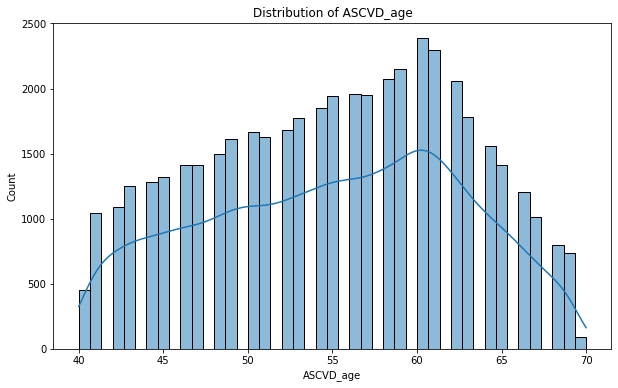

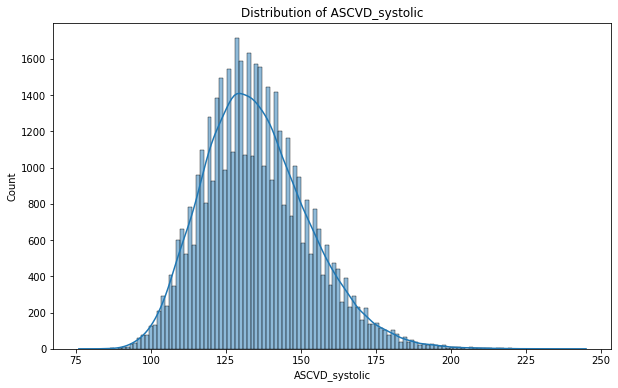

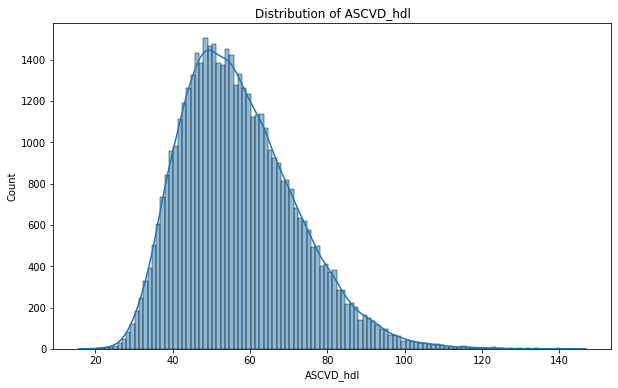

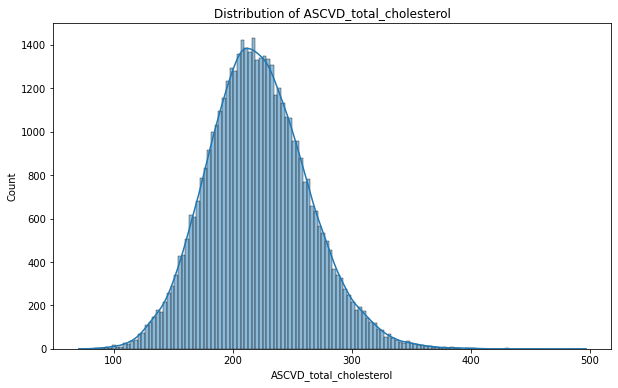

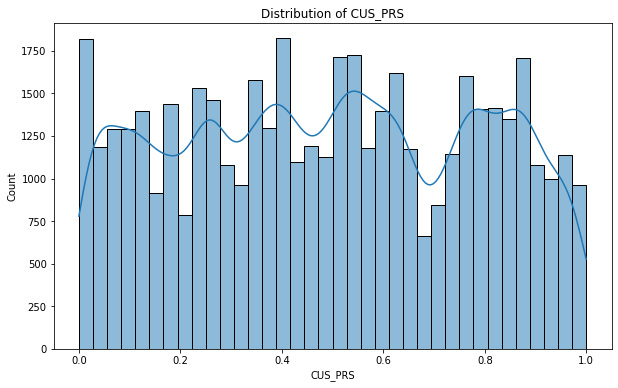

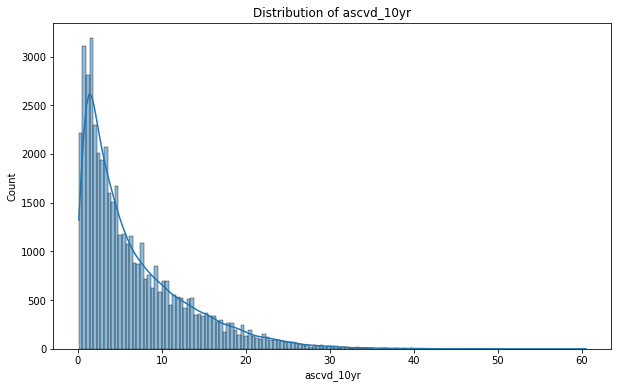

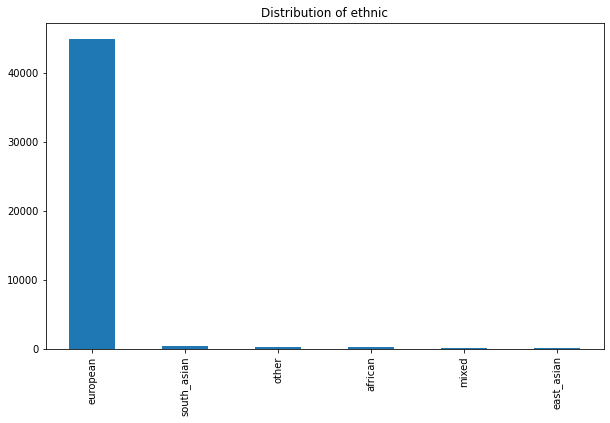

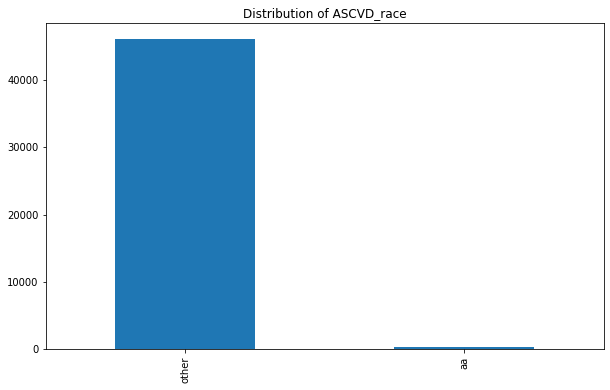

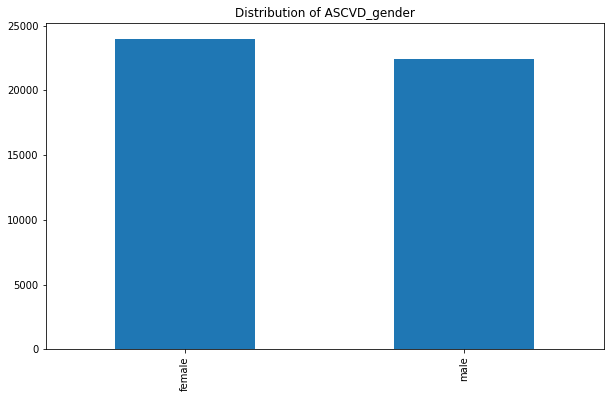

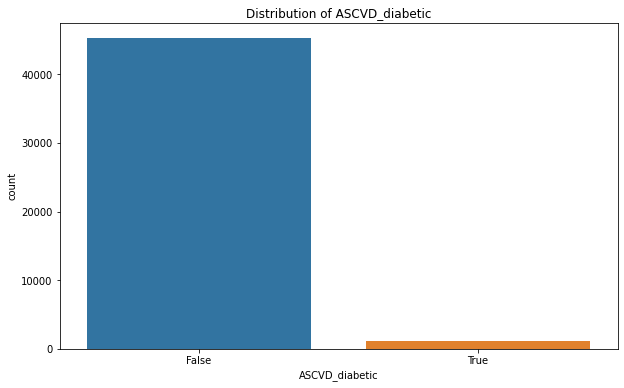

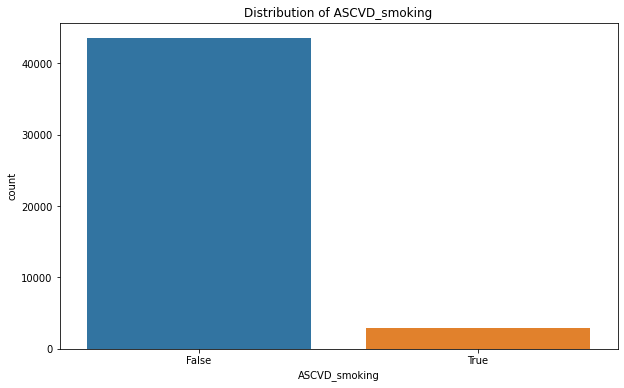

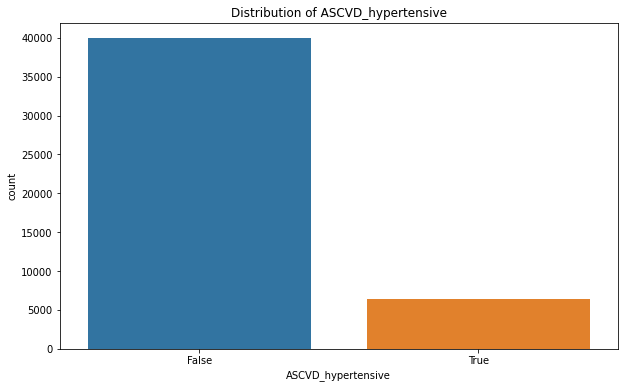

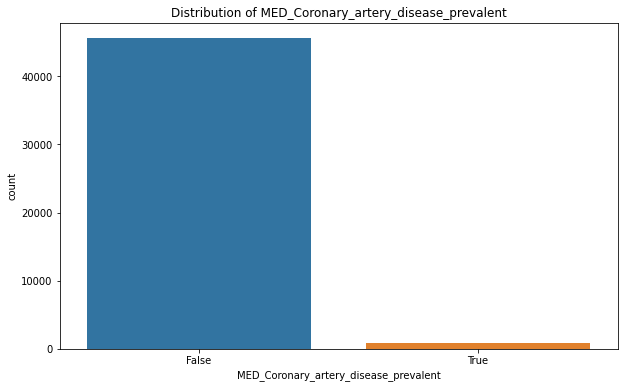

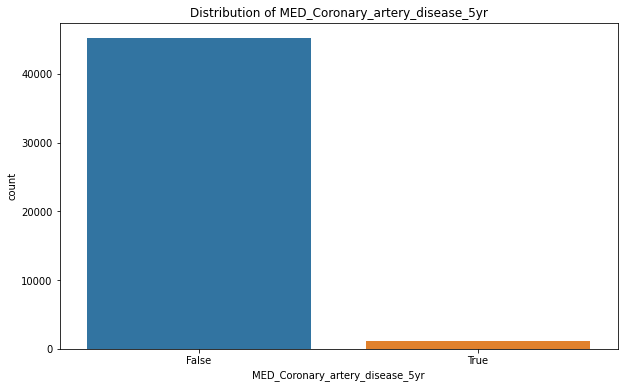

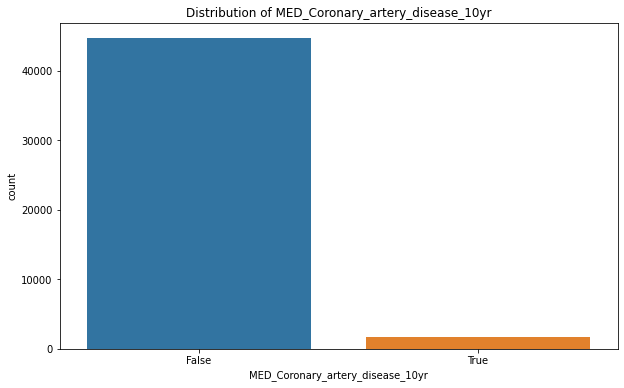

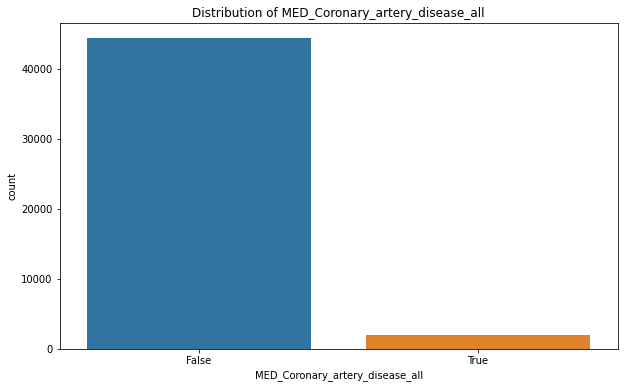

In [9]:
# Define the types of columns
numerical_columns = ['ASCVD_age', 'ASCVD_systolic', 'ASCVD_hdl', 'ASCVD_total_cholesterol', 'CUS_PRS', 'ascvd_10yr']+visit0_df.columns
categorical_columns = ['ethnic', 'ASCVD_race', 'ASCVD_gender']
boolean_columns = ['ASCVD_diabetic', 'ASCVD_smoking', 'ASCVD_hypertensive', 'MED_Coronary_artery_disease_prevalent', 
                   'MED_Coronary_artery_disease_5yr', 'MED_Coronary_artery_disease_10yr', 'MED_Coronary_artery_disease_all']

# Plotting histograms for numerical columns
for col in numerical_columns:
    plt.figure(figsize=(10,6))
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

# Plotting bar charts for categorical columns
for col in categorical_columns:
    plt.figure(figsize=(10,6))
    df[col].value_counts().plot(kind='bar')
    plt.title(f'Distribution of {col}')
    plt.show()

# Plotting count plots for boolean columns
for col in boolean_columns:
    plt.figure(figsize=(10,6))
    sns.countplot(data=df, x=col)
    plt.title(f'Distribution of {col}')
    plt.show()


In [91]:
ASCVD_features = ['eid',
 'ASCVD_age',
 'ASCVD_diabetic',
 'ASCVD_smoking',
 'ASCVD_hypertensive',
 'ASCVD_systolic',
 'ASCVD_hdl',
 'ASCVD_total_cholesterol',
 'MED_Coronary_artery_disease_prevalent',
 'MED_Coronary_artery_disease_5yr',
 'MED_Coronary_artery_disease_10yr',
 'MED_Coronary_artery_disease_all',
 'CUS_PRS',
 'ascvd_10yr']

In [90]:
correlation_matrix

,eid,ASCVD_age,ASCVD_diabetic,ASCVD_smoking,ASCVD_hypertensive,ASCVD_systolic,ASCVD_hdl,ASCVD_total_cholesterol,MED_Coronary_artery_disease_prevalent,MED_Coronary_artery_disease_5yr,...,WT_AHA_8 (mm),WT_AHA_9 (mm),WT_AHA_10 (mm),WT_AHA_11 (mm),WT_AHA_12 (mm),WT_AHA_13 (mm),WT_AHA_14 (mm),WT_AHA_15 (mm),WT_AHA_16 (mm),WT_Global (mm)
eid,1.000000,0.001654,-0.005220,-0.006788,0.001972,-0.006513,0.007499,0.002727,-0.003999,0.001064,...,-0.002386,-0.003472,-0.006256,-0.008392,-0.006022,-0.006685,-0.004219,-0.005950,-0.009016,-0.009754
ASCVD_age,0.001654,1.000000,0.066656,-0.065758,0.220165,0.313033,0.041355,0.107024,0.099660,0.109705,...,0.088648,0.114495,0.064644,0.026047,0.057253,0.059869,0.074011,0.048528,0.058165,0.086616
ASCVD_diabetic,-0.005220,0.066656,1.000000,0.002956,0.197081,0.033417,-0.109929,-0.178709,0.078449,0.074661,...,0.088106,0.094971,0.093590,0.104098,0.106317,0.077116,0.075856,0.078331,0.080605,0.104435
ASCVD_smoking,-0.006788,-0.065758,0.002956,1.000000,-0.026641,-0.032445,-0.060074,0.004195,0.004420,0.014660,...,0.061249,0.055466,0.059712,0.071016,0.080303,0.061422,0.060277,0.057715,0.056423,0.072581
ASCVD_hypertensive,0.001972,0.220165,0.197081,-0.026641,1.000000,0.196905,-0.136751,-0.176524,0.208400,0.190381,...,0.162654,0.185487,0.179427,0.170600,0.178955,0.144643,0.148958,0.143186,0.146526,0.191760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WT_AHA_13 (mm),-0.006685,0.059869,0.077116,0.061422,0.144643,0.252743,-0.360196,-0.047976,0.078460,0.082373,...,0.727457,0.687570,0.683055,0.683589,0.731368,1.000000,0.800374,0.738973,0.821812,0.759385
WT_AHA_14 (mm),-0.004219,0.074011,0.075856,0.060277,0.148958,0.265268,-0.383511,-0.049533,0.080873,0.084744,...,0.725552,0.784386,0.757546,0.730841,0.726107,0.800374,1.000000,0.833730,0.744855,0.777196
WT_AHA_15 (mm),-0.005950,0.048528,0.078331,0.057715,0.143186,0.248000,-0.366024,-0.068009,0.077072,0.080337,...,0.676969,0.743597,0.762940,0.744456,0.718047,0.738973,0.833730,1.000000,0.809857,0.755950
WT_AHA_16 (mm),-0.009016,0.058165,0.080605,0.056423,0.146526,0.246989,-0.359605,-0.055103,0.086591,0.088747,...,0.655529,0.676391,0.684224,0.723685,0.738085,0.821812,0.744855,0.809857,1.000000,0.741165


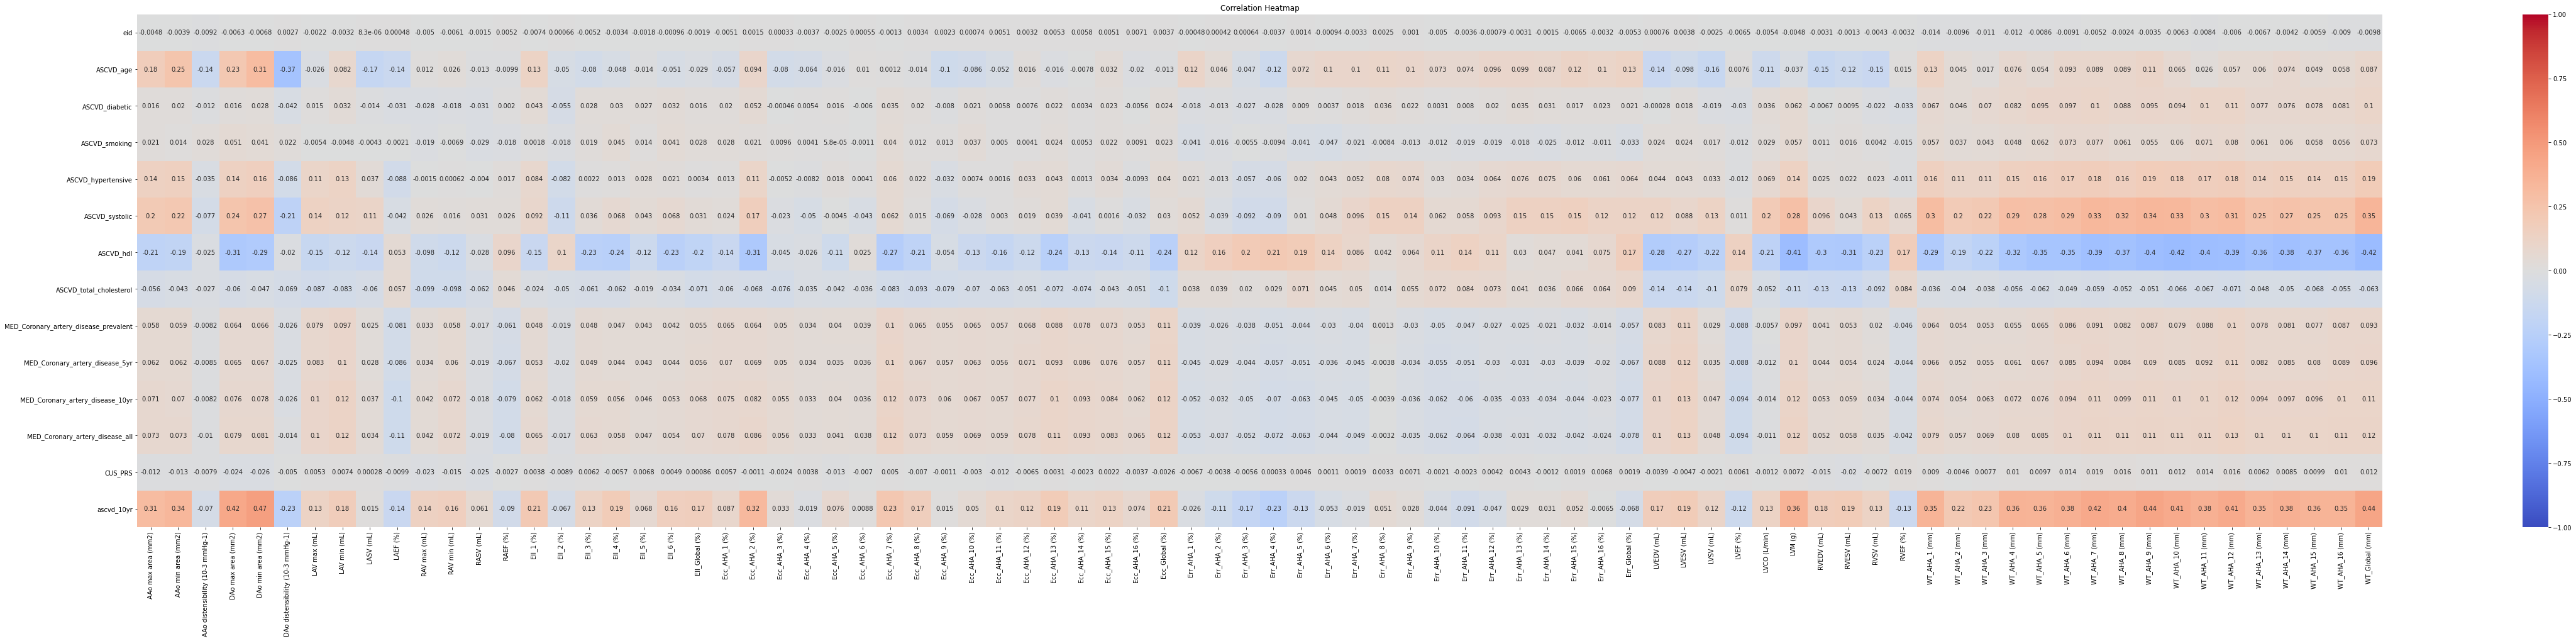

In [96]:
# Assuming df is your dataframe
# ASCVD_features
# image_features
sub_df = visit0_df[ASCVD_features + image_features]
correlation_matrix = sub_df.corr()

extracted_corr = correlation_matrix.loc[ASCVD_features, image_features]



plt.figure(figsize=(80,15))
sns.heatmap(extracted_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.savefig("ASCVD_image_heatmap.png", dpi=300)
plt.show()